In [7]:
%reload_ext autoreload
%autoreload 2


In [8]:
import torch
import matplotlib.pyplot as plt
from estimators.data import TraversabilityDataset, get_transform
from estimators.data.TraversabilityDataset import PatchesDataset
from estimators.utils import get_learner
from utilities.postprocessing.utils import KrockPatchExtractStrategy
from utilities.patches import *
from interpretability import *
from utilities.patches import *
from jupyterthemes import jtplot
from estimators.utils import load_model_from_name
import matplotlib
import os


In [9]:
from jupyterthemes import jtplot
jtplot.reset()
#
plt.style.use(['science', 'ieee'])
# matplotlib.rcParams['figure.figsize'] = (12,12)
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

# Parameters

In [11]:
model_name = 'microresnet#3-gate=7x7-n=1-se=True'
model_dir = '/media/francesco/Carino/vaevictis/data/1558825182.753924'
# model_dir = '/media/francesco/Carino/vaevictis/data/1559690958.4176426'

BASE_DIR = '/media/francesco/saetta/krock-dataset/test/'
TEST_META = BASE_DIR + '/meta.csv'

TEST_ROOT = '/media/francesco/saetta/krock-dataset/new-test-random/csvs_patches'
PATCHES_DIR = '/media/francesco/saetta/krock-dataset/new-test-random/patches/0.71/'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
module = load_model_from_name(model_dir + '/roc_auc.pth', model_name )
module = module.eval().to(device)

MAX_ADVANCEMENT = 0.70
seconds = 4
time_window = 100
device

device(type='cuda')

# Analize Quarry Test Set
We are going to use the test set created from simulations run on the Quarry map to understand the model behaviour. We will try to answer different questions, such as "Which are the easiest traversable patches?" or "Are they any ground feature that can misslead the model?".

In [ ]:
ds = TraversabilityDataset.from_root(TEST_ROOT, patches_dir=PATCHES_DIR, time_window = 50*2, patch_size=0.7, tr=0.2, transform=get_transform(debug=False))
learner, _ = get_learner(model_name, model_dir, [], dataset=ds)
explain = ExplainModel.from_leaner(learner, ds)

In [ ]:
explain.by_looking_at().tell(ClassificationAnswer.from_explain).plot_confusion_matrix()

## Visualize the best and worst patches sorted by advancement

In [ ]:
explanations = explain.by_looking_at([ Best(), Worst()],how_many=10, every=250)
base_dir = '/home/francesco/Documents/Master-Thesis/papers/Thesis/img/5/quarry/all/'

for name, explanation in explanations.items():
        explanation.df = explanation.df.sort_values('advancement')
        print(explanation.df['advancement'])
        answers = explanation.tell(PatchAnswer.from_explain) 
        save_dir = '{}/{}'.format(base_dir, name)
        os.makedirs(save_dir, exist_ok=True)
        for i, answer in enumerate(answers):
            answer.plot3d_mayavi(0.02, size=(513,513), distance=3.5, save_path='{}/{:02d}-patch-3d-majavi-colormap-{}.png'.format(save_dir, int(explanation.df['advancement'].iloc[i] * 100), i), azimuth=0, elevation=35, mesh=True, colormap='viridis', vmax=1)


## Most traversable patches
We expect the esiest traversable patches to be mostly flat. The following figure shows five patches sorted by the *traversable* class probability from the test set.

In [ ]:
explanations = explain.by_looking_at([
                                      Shuffle(FalsePositive()),
                                      Shuffle(FalseNegative()),
                                      Shuffle(Worst()),
                                      Shuffle(Best()),
                                     ], how_many=5)

In [ ]:
explanations['best'].tell(PatchAnswer.from_explain)[0].plot3d_mayavi(0.02, size=(513,513), distance=3.5, save_path='/home/francesco/Desktop/diocane.png', azimuth=0, elevation=35, mesh=True, colormap='viridis', vmax=1)

In [ ]:
import os
plt.style.use(['science', 'ieee'])
module = module.eval()
class MyExplanationsSaver():
    def __init__(self, base_dir):
        self.base_dir = base_dir
            
    def __call__(self, explanations):
        for name, explanation in explanations.items():
            answers = explanation.tell(PatchAnswer.from_explain)
            save_dir = '{}/{}'.format(self.base_dir, name)
            os.makedirs(save_dir, exist_ok=True)
            print(answers)
            for i, answer in enumerate(answers):
                answer.plot2d().savefig('{}/patch-2d-{}'|.format(save_dir,i), bbox_inches='tight', transparent=True)
                answer.grad_cam(module.eval(), device, target_class=0).plot2d().savefig('{}/grad-cam-2d-{}'.format(save_dir,i), bbox_inches='tight', transparent=True)
                answer.heatmap((8,8)).plot2d().savefig('{}/heatmap-2d-{}'.format(save_dir,i), bbox_inches='tight', transparent=True)
                answer.plot3d(title='', rstride=1, cstride=1,)[0].savefig('{}/patch-3d-{}'.format(save_dir,i), bbox_inches='tight', transparent=True)
                answer.plot3d_mayavi(0.02, size=(513,513), distance=3.5, save_path='{}/patch-3d-majavi-colormap-{}.png'.format(save_dir,i), azimuth=0, elevation=35, mesh=True, colormap='viridis', vmax=1)
                plt.close("all")
                
MyExplanationsSaver('/home/francesco/Documents/Master-Thesis/papers/Thesis/img/5/quarry/')(explanations)

In [ ]:
def plot_answer(answer):
    answer.plot2d()
    answer.grad_cam(module, device).plot2d()
    answer.heatmap((8,8)).plot2d()
#     _ = answer.plot3d()[0]

Clearly, most of the patches are flat. The first patch is entirery flat, looking at the heights we can see that every value is zero. Interesting, the grad cam thinks highlights the middle of the patch. Grad cam creates a circle in the middle where the maximum activation point is exactly at the Krock's head position, 36 pixels from the left. Interesting, the highligthed region corespond to the Krock position while walking in flat ground. Correctly the full Krock footprint is highligthed while the corners are not taken into account since the robot won't ever reach them. So, our model is looking at the head position, at the robot footprint and at the future possible reachable region.

In [ ]:
answers = explanations['best'].tell(PatchAnswer.from_explain)

plot_answer(answers[0])

In [ ]:
for answers in explanations.values():
    for answer in answers:
        answers[idx].plot2d()
        answers[idx].grad_cam(module, device).plot2d()
        answers[idx].heatmap((8,8)).plot2d()
        _ = answers[idx].plot3d()[0]
# answers[idx].add_advancement_using_simulator(3, 100).plot2d()

In [ ]:
Patch.plot_all_2d(answers)

In [ ]:
import gc

gc.collect()

# Custom Patches


We can test the robustness of the model by creating custom patches with trivial geometric shapes, walls/bumps, and test the model by comparing its prediction to the real robot in the simulator.

In [19]:

def get_distance(offsets):
    from_left = patch_shape[1] - offsets - size 
    return (from_left - (krock_body + 8)) * 2

def get_answers_from_patches(patches):
    walls_ds = PatchesDataset(patches=patches, transform=get_transform())
    learner, _ = get_learner(model_name, model_dir, [], dataset=walls_ds)
    learner.model = learner.model.eval()
    explain = ExplainModel.from_leaner(learner, walls_ds)
    answer = explain.tell(answer=CustomPatchAnswer.from_explain)
    return answer, explain

def store_figures(figures, out_path):
    for i, fig in enumerate(figures):
        fig[0].savefig('{}{}.png'.format(out_path,i), bbox_inches='tight', transparent=True)
        
def save2d_and_2d(p, out_dir, n):
    p.plot2d().savefig(out_dir + '/{}-2d.png'.format(n))
    p.plot3d_mayavi(0.02, size=(513,513), distance=3.5, save_path=out_dir + '/{}-3d.png'.format(n), azimuth=0, elevation=35, mesh=True, colormap='viridis', vmax=1)
    
    
def make_heatmap(data):
    pred_reshape = data.values.reshape(len(heights), len(offsets_rev))
    matplotlib.rcParams['figure.figsize'] = (16,14)

    fig = plt.figure()
    ax = sns.heatmap(pred_reshape, annot=pred_reshape, 
                     cmap='viridis',
                     fmt='.2f', 
                     )
    ax.set_yticklabels(['{:.1f}'.format(h * 100) for h in heights], rotation=0)
    ax.set_xticklabels([int(d) for d in  distance],  rotation=0)
    ax.set_ylabel('Height (cm)',  fontsize=18)
    ax.set_xlabel('Distance from Krock\'s head (cm)',  fontsize=18)

    plt.show()
    return fig

## Walls at different positions in front of Krock
The most trival way to correctly test the model is to place different walls in front of krock at an increasing distance. The wall is 1 meter high, so it is not traversable, but we had a treshold of 20cm, meaning that, even if the wall is not traversable, when it is at more than 20cm from krock on flat ground the model should yield true. We are going to test the model with different patches starting with a wall placed exactly in front of the robot, then we will move the wall one cm at the time till the end of the patch.

In [14]:
out_dir = '/home/francesco/Documents/Master-Thesis/papers/Thesis/img/5/custom_patches/walls_front'
patch_shape = KrockPatchExtractStrategy.patch_shape(MAX_ADVANCEMENT)
size = 8
res = 0.02
krock_body = 36
surely_in_front_of_krock = krock_body + 8 + size  # head is at 14cm (7px) from the krock's pose
from_right = patch_shape[0] - surely_in_front_of_krock

offsets = np.arange(0, from_right)

offsets = np.unique(offsets.astype(np.int))

In [195]:
offsets

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25])

In [196]:
walls = [WallPatch(KrockPatchExtractStrategy.patch_shape(MAX_ADVANCEMENT), strength=1, back=False, offset=int(offset), size=size)() for offset in offsets]

answer, explanation = get_answers_from_patches(walls)

26


In [127]:
distance = get_distance(offsets)
explanation.df['distance'] = distance # convert back to cm and to 'in front of krock coordinates'
explanation.df.to_csv(out_dir + 'walls_front.csv')
explanation.df

,out_0,out_1,prediction,distance
0,5.084317e-05,0.999949,1,52
1,2.198216e-25,1.000000,1,50
2,1.184476e-21,1.000000,1,48
3,1.724052e-08,1.000000,1,46
4,0.000000e+00,1.000000,1,44
5,5.225295e-22,1.000000,1,42
6,1.645591e-24,1.000000,1,40
7,0.000000e+00,1.000000,1,38
8,0.000000e+00,1.000000,1,36
9,0.000000e+00,1.000000,1,34


We can say that the model classifies all the wall between 0cm to 19cm from krock's head as no traversable and the ones more than 20cm far away traversable, as expected. Let's use the simulator to get the real advancement of the robot on this ground. We will test the last non traversable and the first traversable

In [134]:
explanation.df = explanation.df[::-1]
explanation.df = explanation.df.reset_index(drop=True)
# distance = explanation.df['distance'].values[::-1]
# distance

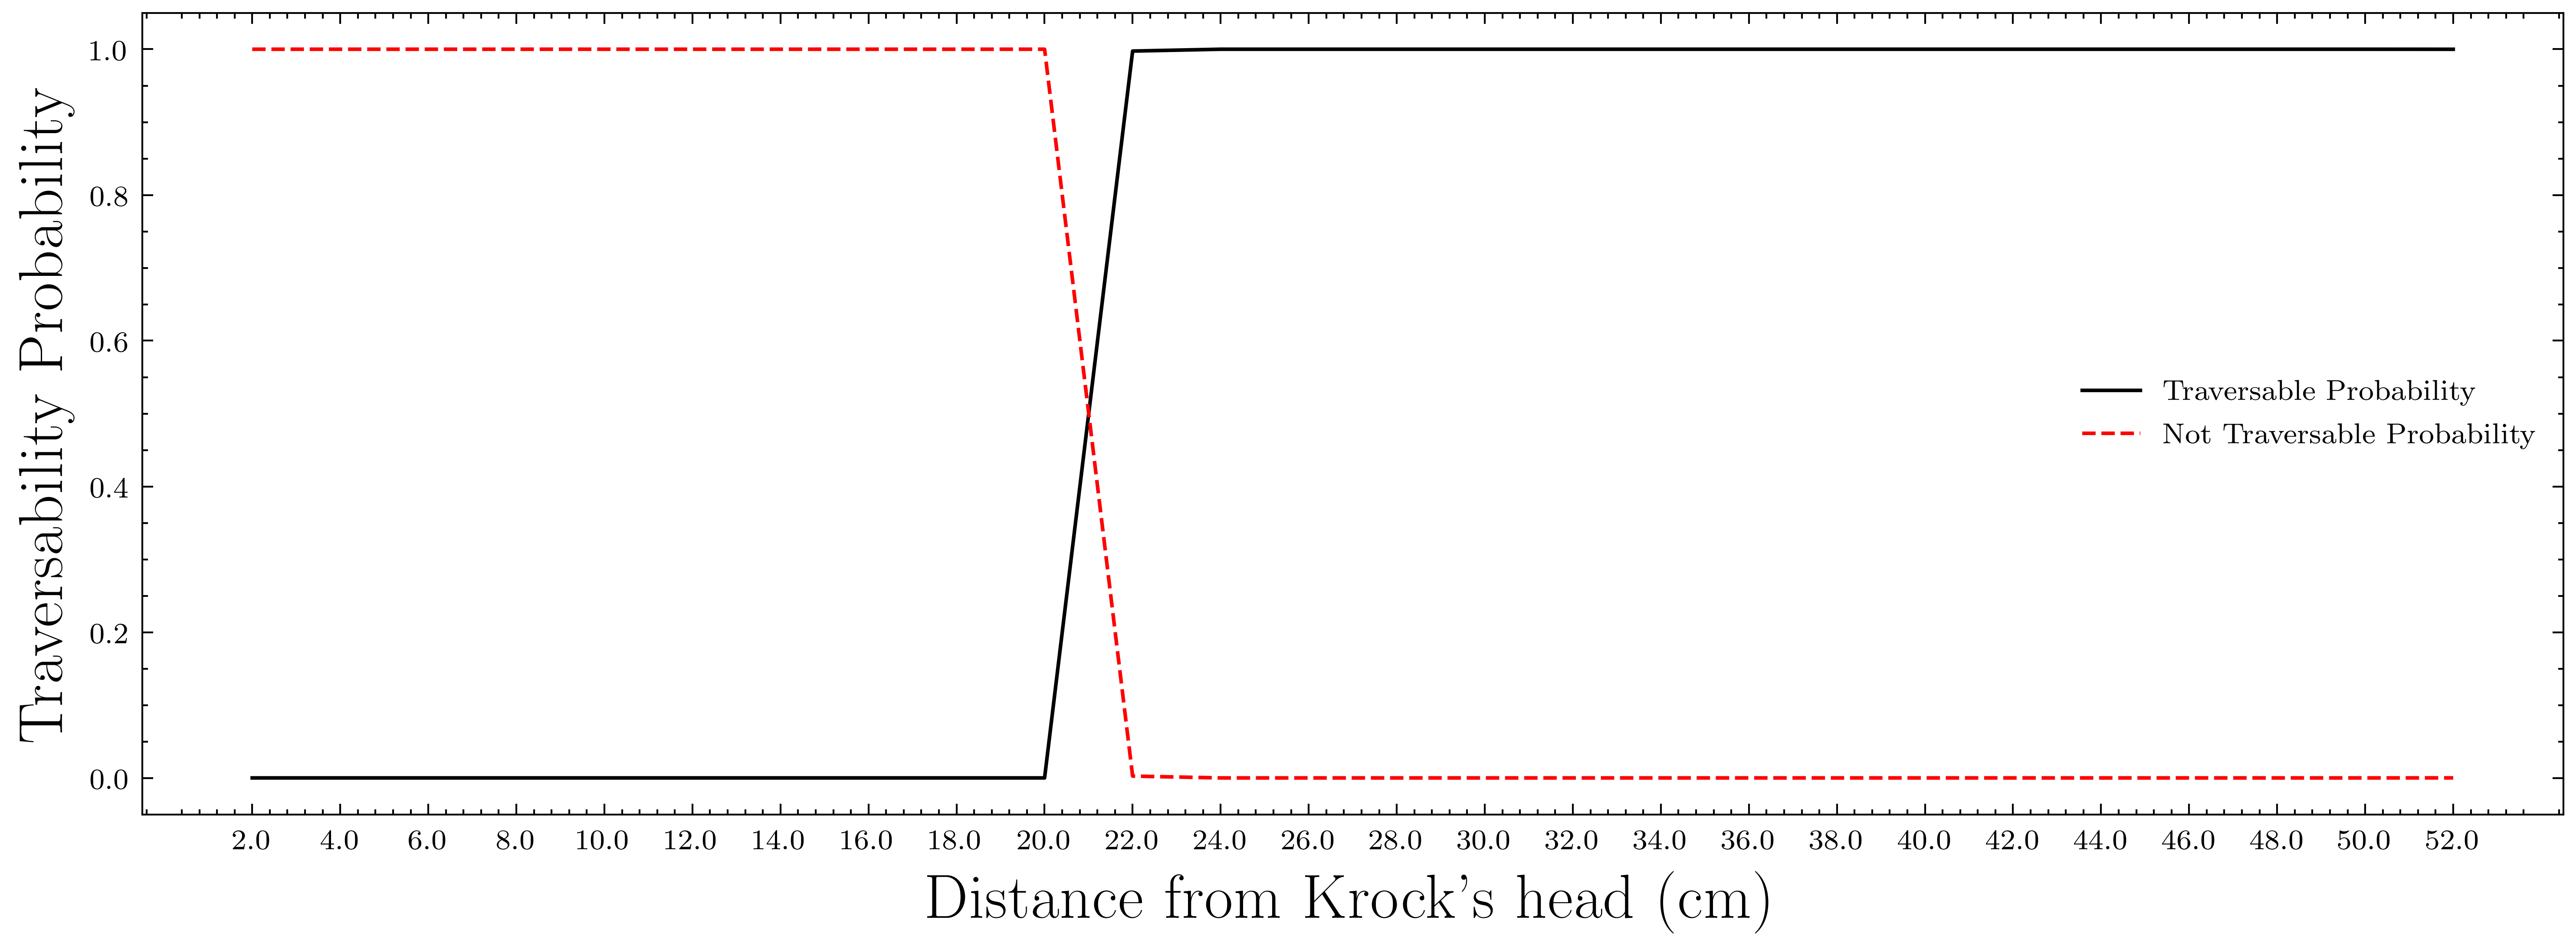

In [135]:
fig = plt.figure()
plt.plot(explanation.df['out_1'], label='Traversable Probability ')
plt.plot(explanation.df['out_0'], label='Not Traversable Probability')
ax = plt.gca()
matplotlib.rcParams['figure.figsize'] = (12,4)
# plt.style.use(['science', 'ieee'])

ax.set_xticks(np.arange(len(distance)))
ax.set_xticklabels(['{:.1f}'.format(d) for d in distance], rotation=0)
ax.set_ylabel('Traversability Probability',  fontsize=18)
ax.set_xlabel('Distance from Krock\'s head (cm)',  fontsize=18)
plt.legend()
plt.show()
fig.savefig(out_dir + '/predictions.png')

In [130]:
plt.style.use(['science', 'ieee'])

answer[15].add_advancement_using_simulator(seconds, time_window)
save2d_and_2d(answer[15], out_dir, 1)
answer[16].add_advancement_using_simulator(seconds, time_window)
save2d_and_2d(answer[16], out_dir, 2)

36 39
success: 1
36 39
success: 1


In [198]:
# store all the walls for the thesis
for n, p in enumerate(answer[::-1]):
    p.plot3d_mayavi(0.02, size=(513,513), distance=3.5, save_path=out_dir + '/all/{:02d}-3d.png'.format(n), azimuth=0, color=(0,0.5,0), elevation=35, mesh=True, vmax=1)

Correctly the advancement in the last traversable is slighty less than 20cm and the one in the first no traversable is more than 20cm. 

### Increase the wall height
We can scale up the first traversable patch to 10meter in order to see if the model still look at the distance and not at the pixel value

In [43]:
big_walls = [Patch.from_hm(walls[-1].hm * 10), Patch.from_hm(walls[-1].hm * 100)]

ans, _ = get_answers_from_patches(big_walls)

2


In [44]:
ans[0].plot2d().savefig(out_dir + '/big-1-2d.png')
ans[1].plot2d().savefig(out_dir + '/big-2-2d.png')

Correctly, the model was not confused by the enourmous height of the wall.

## Walls in front of krock of different height

What is the minimum height for a wall in front of Krock to be traversable? We can asnwer to this question by creating 10 walls from 1cm to 20cm and place them in front of the robot and the comparing the model's output with the advancement getted from the simulator.

In [191]:
out_dir = '/home/francesco/Documents/Master-Thesis/papers/Thesis/img/5/custom_patches/walls_increasing'

heights = np.arange(0, 20) / 100
walls = [WallPatch(KrockPatchExtractStrategy.patch_shape(MAX_ADVANCEMENT), strength=s, back=False, offset=offsets[-1], size=size)() 
         for s in heights ]

In [192]:
answer, explanation = get_answers_from_patches(walls)

20


In [113]:
explanation.df['height'] = heights
explanation.df.to_csv('/home/francesco/Documents/Master-Thesis/papers/Thesis/img/5/custom_patches/walls_increasing/prediction.csv')
explanation.df

,out_0,out_1,prediction,height
0,5.084239e-05,9.999491e-01,1,0.00
1,1.591915e-05,9.999840e-01,1,0.01
2,1.575231e-06,9.999985e-01,1,0.02
3,1.753777e-07,9.999999e-01,1,0.03
4,8.631183e-07,9.999992e-01,1,0.04
5,3.525285e-06,9.999964e-01,1,0.05
6,1.012329e-05,9.999899e-01,1,0.06
7,3.412054e-05,9.999659e-01,1,0.07
8,1.055946e-03,9.989441e-01,1,0.08
9,3.097092e-02,9.690291e-01,1,0.09


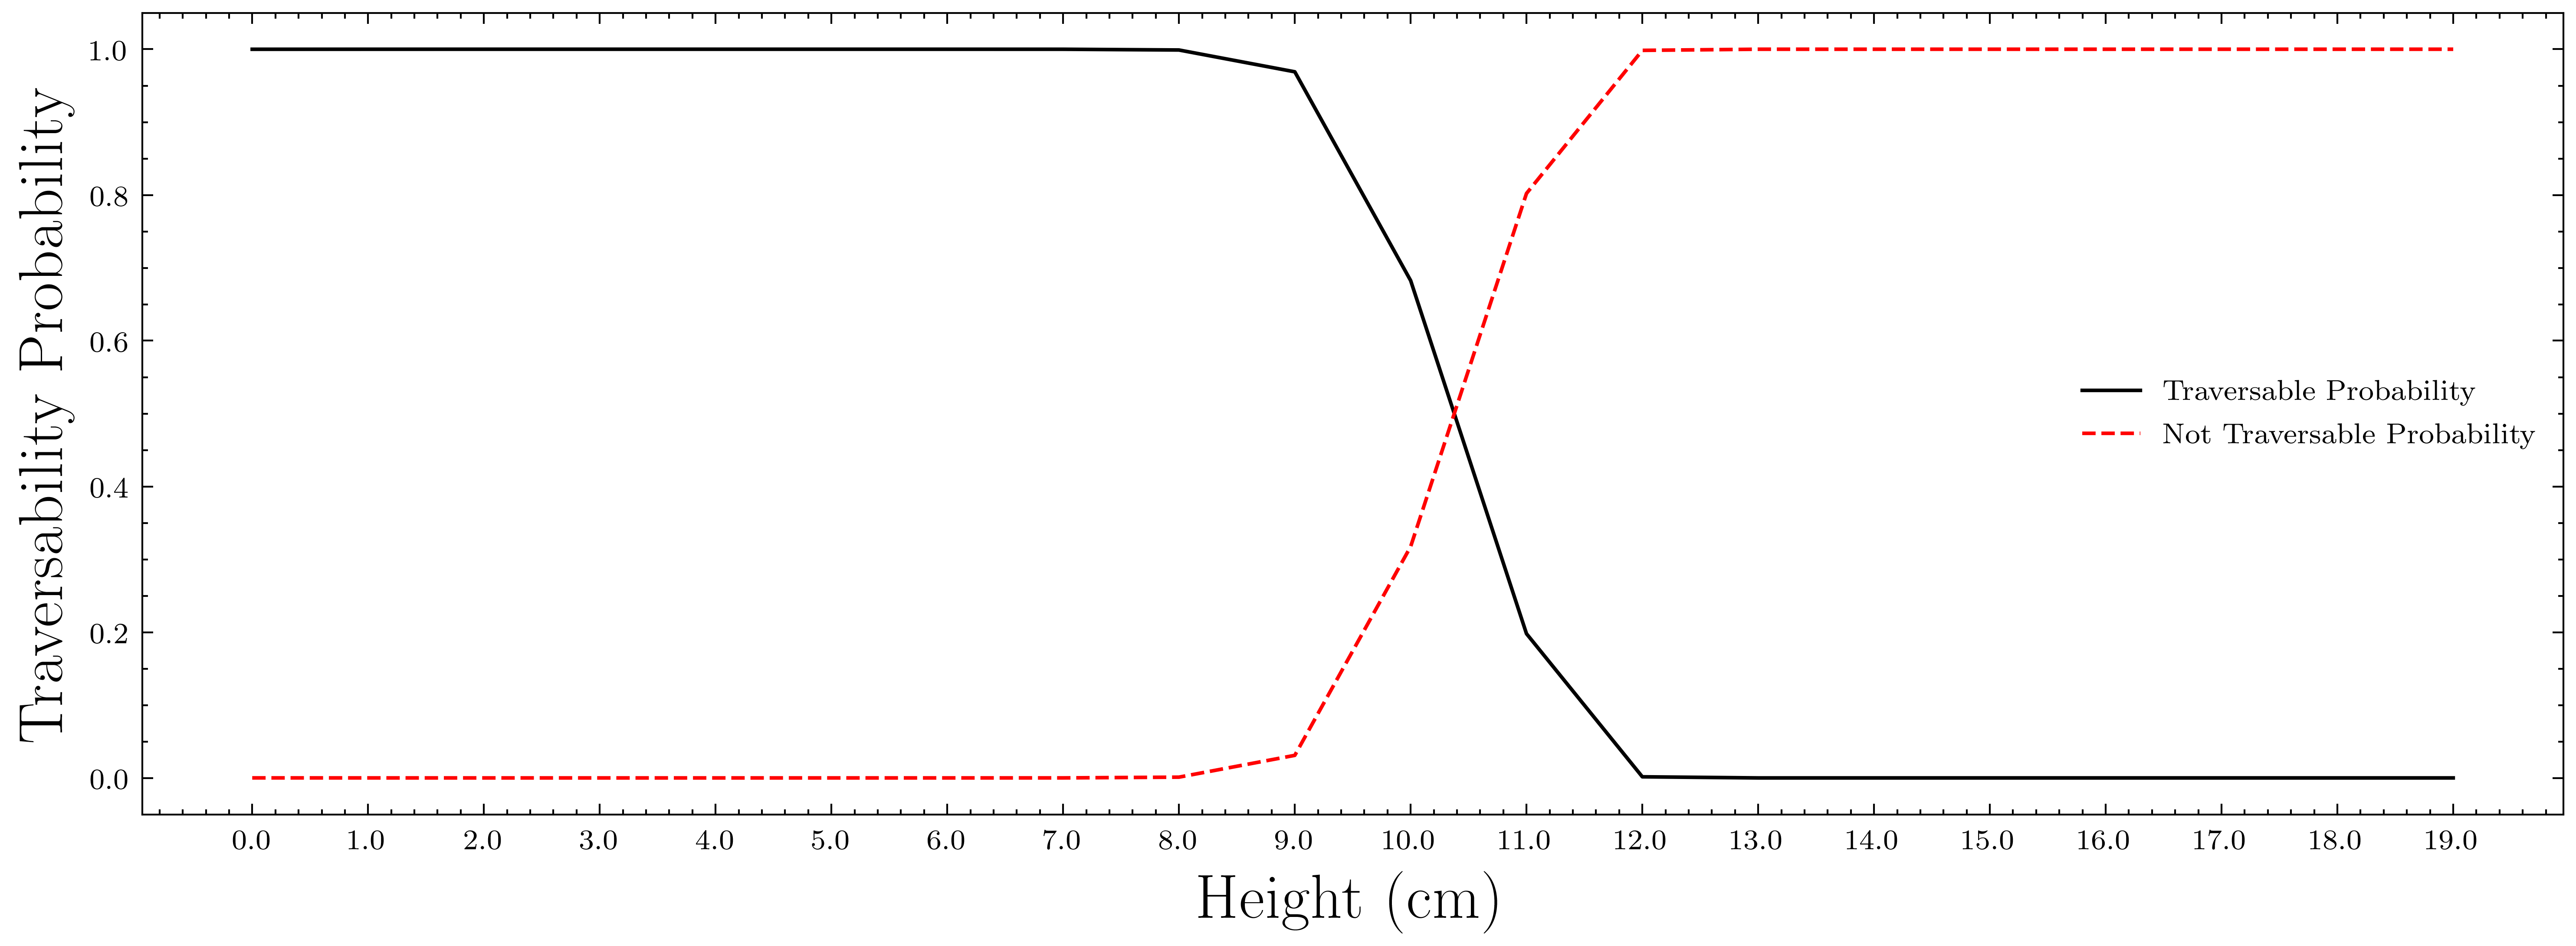

In [120]:
fig = plt.figure()
plt.plot(explanation.df['out_1'], label='Traversable Probability ')
plt.plot(explanation.df['out_0'], label='Not Traversable Probability')
ax = plt.gca()

ax.set_xticks(np.arange(len(heights)))
ax.set_xticklabels(['{:.1f}'.format(d) for d in heights * 100], rotation=0)
matplotlib.rcParams['figure.figsize'] = (12,4)
ax.set_xlabel('Height (cm)',  fontsize=18)
ax.set_ylabel('Traversability Probability',  fontsize=18)
plt.legend()
plt.show()
fig.savefig(out_dir + '/predictions.png')

In [193]:
# store all the walls for the thesis
for n, p in enumerate(answer):
    p.plot3d_mayavi(0.02, size=(513,513), distance=3.5, save_path=out_dir + '/all/{:02d}-3d.png'.format(n), azimuth=0, color=(0,0.5,0), elevation=35, mesh=True, vmax=1)

In [118]:
seconds = 5
time_window = 100
# matplotlib.rcParams['figure.figsize'] = (12,12)
plt.style.use(['science', 'ieee'])

answer[10].add_advancement_using_simulator(seconds, time_window)
save2d_and_2d(answer[10], out_dir, 1)
answer[11].add_advancement_using_simulator(seconds, time_window)
save2d_and_2d(answer[11], out_dir, 2)


36 39
success: 1


# Height/Distance walls
Let's create different walls with different heights at different distances

In [12]:
out_dir = '/home/francesco/Documents/Master-Thesis/papers/Thesis/img/5/custom_patches/walls_heights/'


In [22]:
heights = np.arange(5, 20) / 100 # 5cm to 20cm
heights = heights[::-1]
offsets_rev = offsets[11:][::-1] # from 0 to 30 cm from Krock
combinations = [(h,o) for h in heights for o in offsets_rev]

patches = [WallPatch(patch_shape, strength=h, back=False, offset=o, size=size)() 
         for (h,o) in combinations]

In [25]:
answer, explanation = get_answers_from_patches(patches)
explanation.df['height'] = [h for (h,o) in combinations]
explanation.df['offset'] = [o for (h,o) in combinations]
distance =  get_distance(offsets_rev)

explanation.df.to_csv(out_dir + '/predictions.csv')

225


### Heatmap

/home/francesco/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/francesco/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


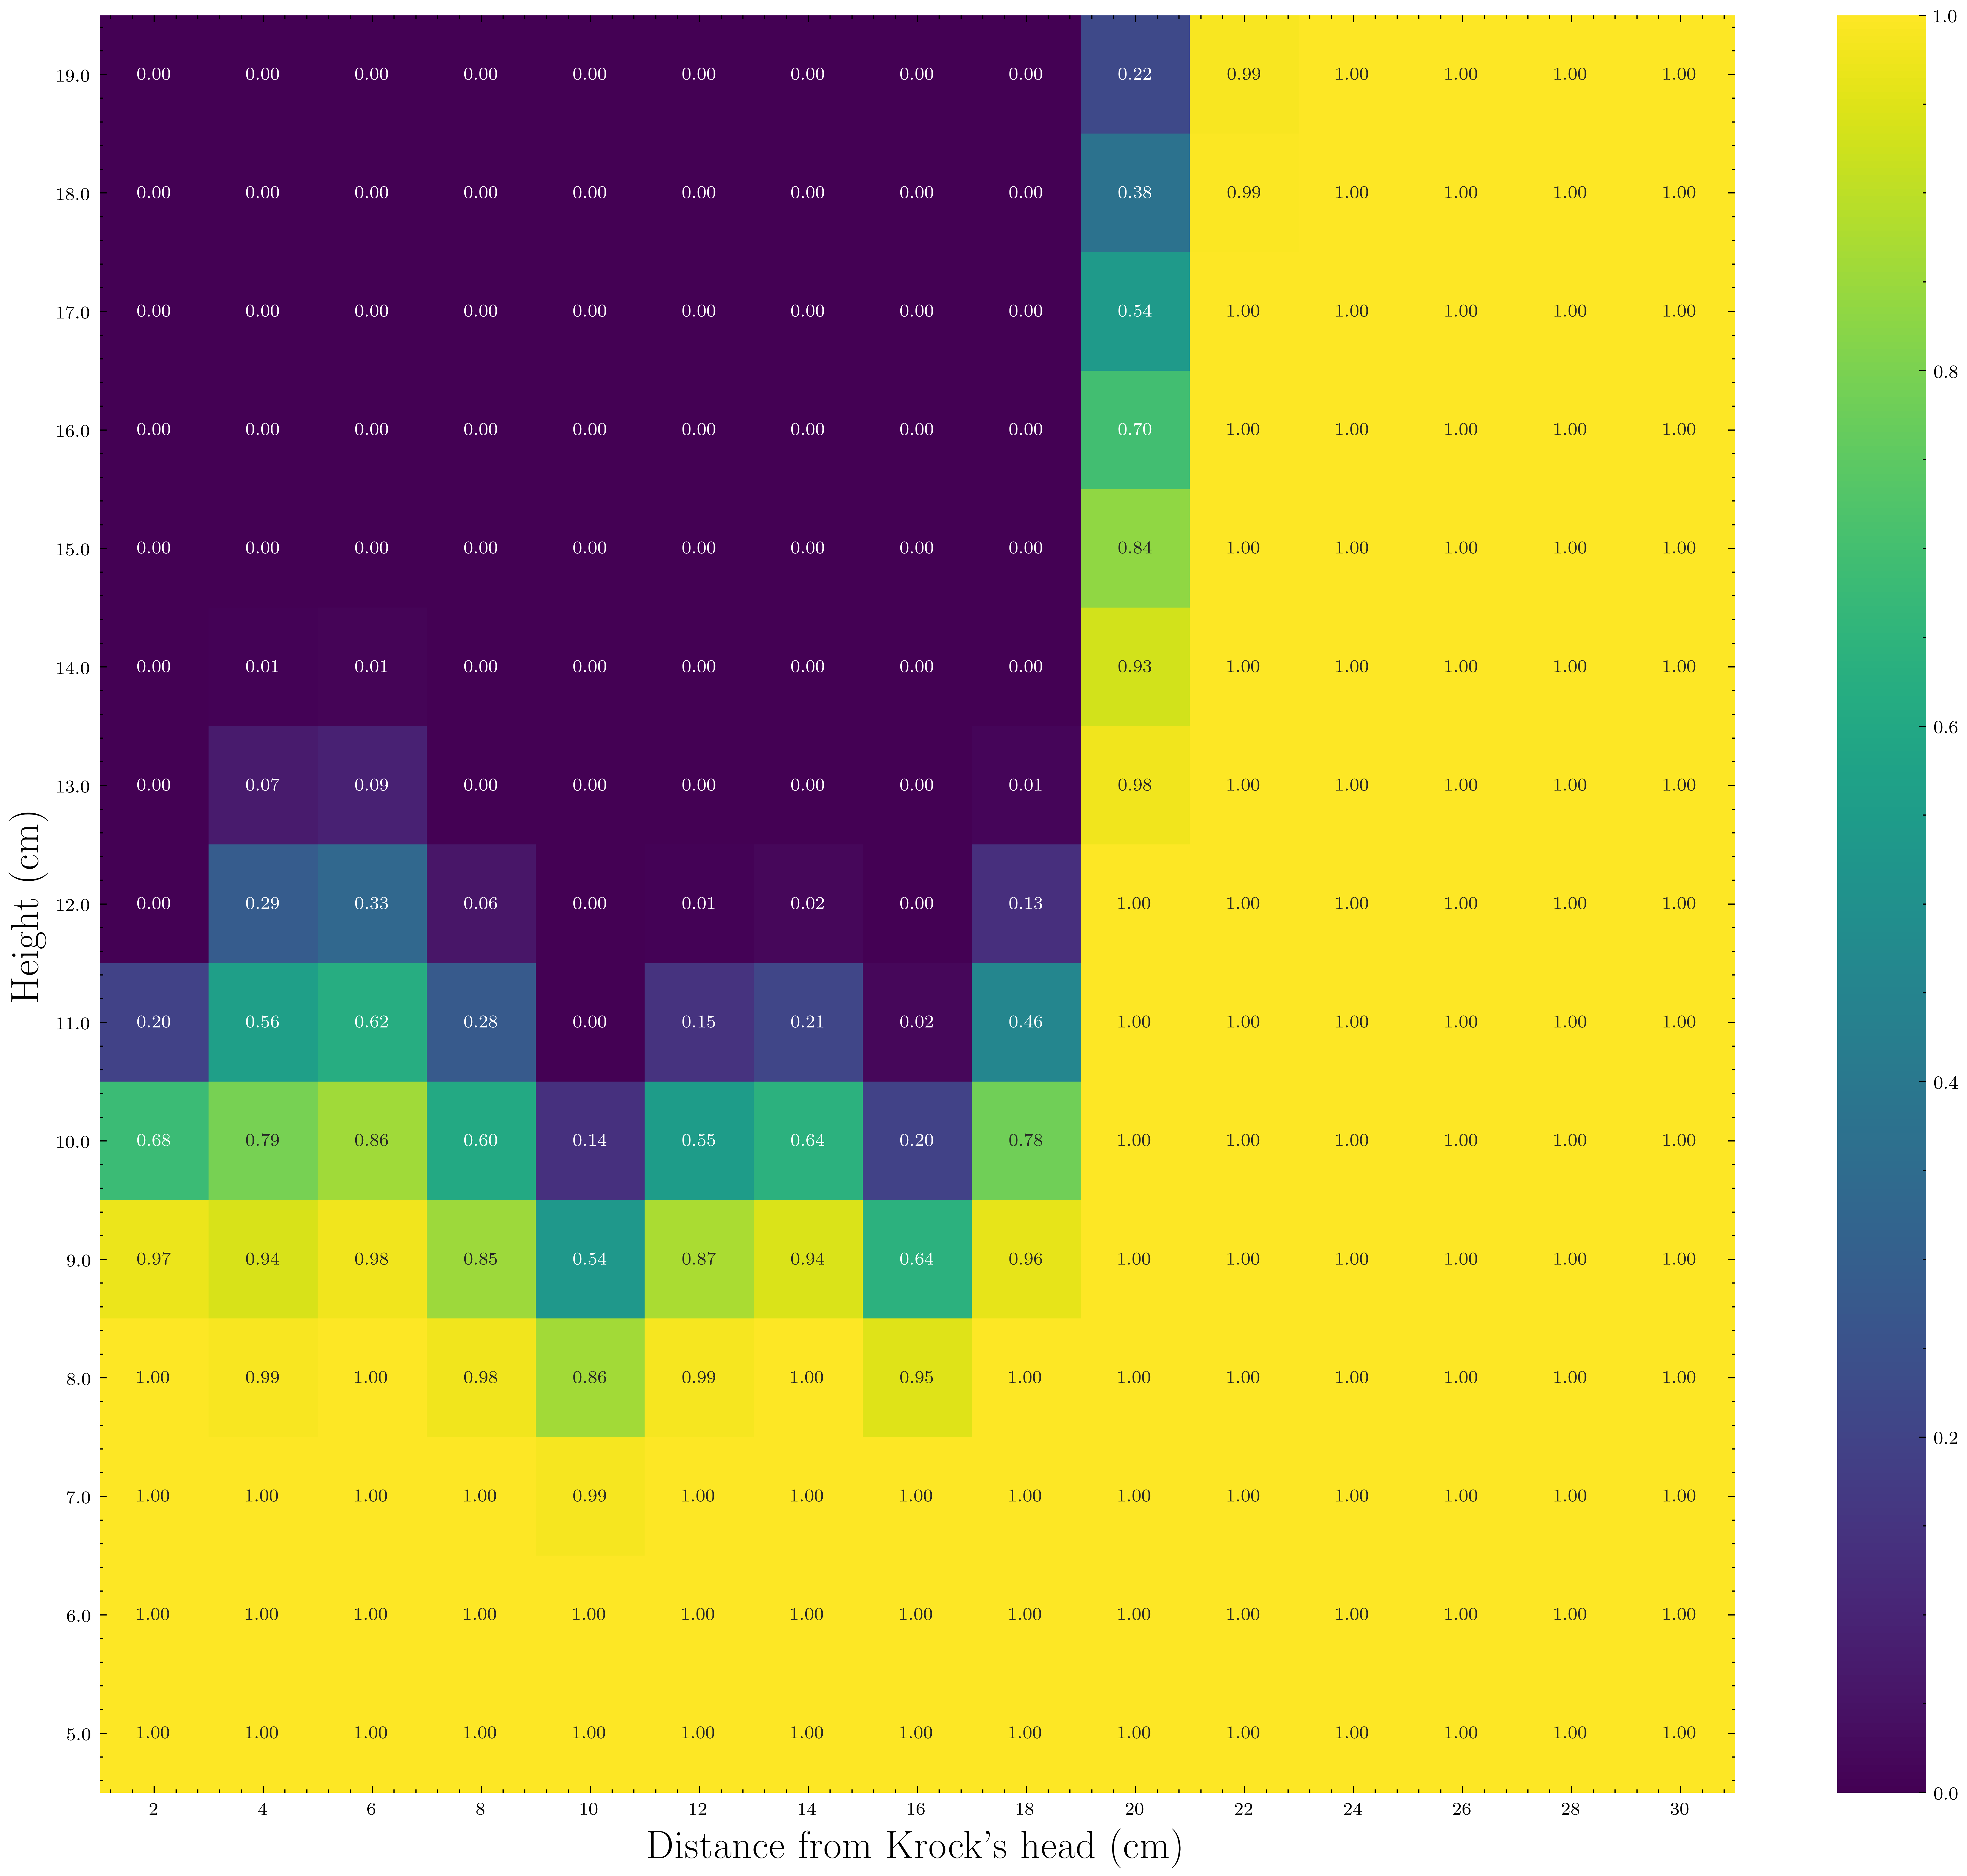

In [45]:
fig = make_heatmap(explanation.df['out_1'])
fig.savefig(out_dir + '/walls_heights.png', transparent=True)

### Ground truth 
We computed the real advancement for each patch

In [26]:
ground_truth = pd.read_csv('/home/francesco/Documents/Master-Thesis/papers/Thesis/img/5/custom_patches/walls_heights/advancements.csv')
advancements = ground_truth[['advancements_25', 'advancements_50']].max(axis=1)



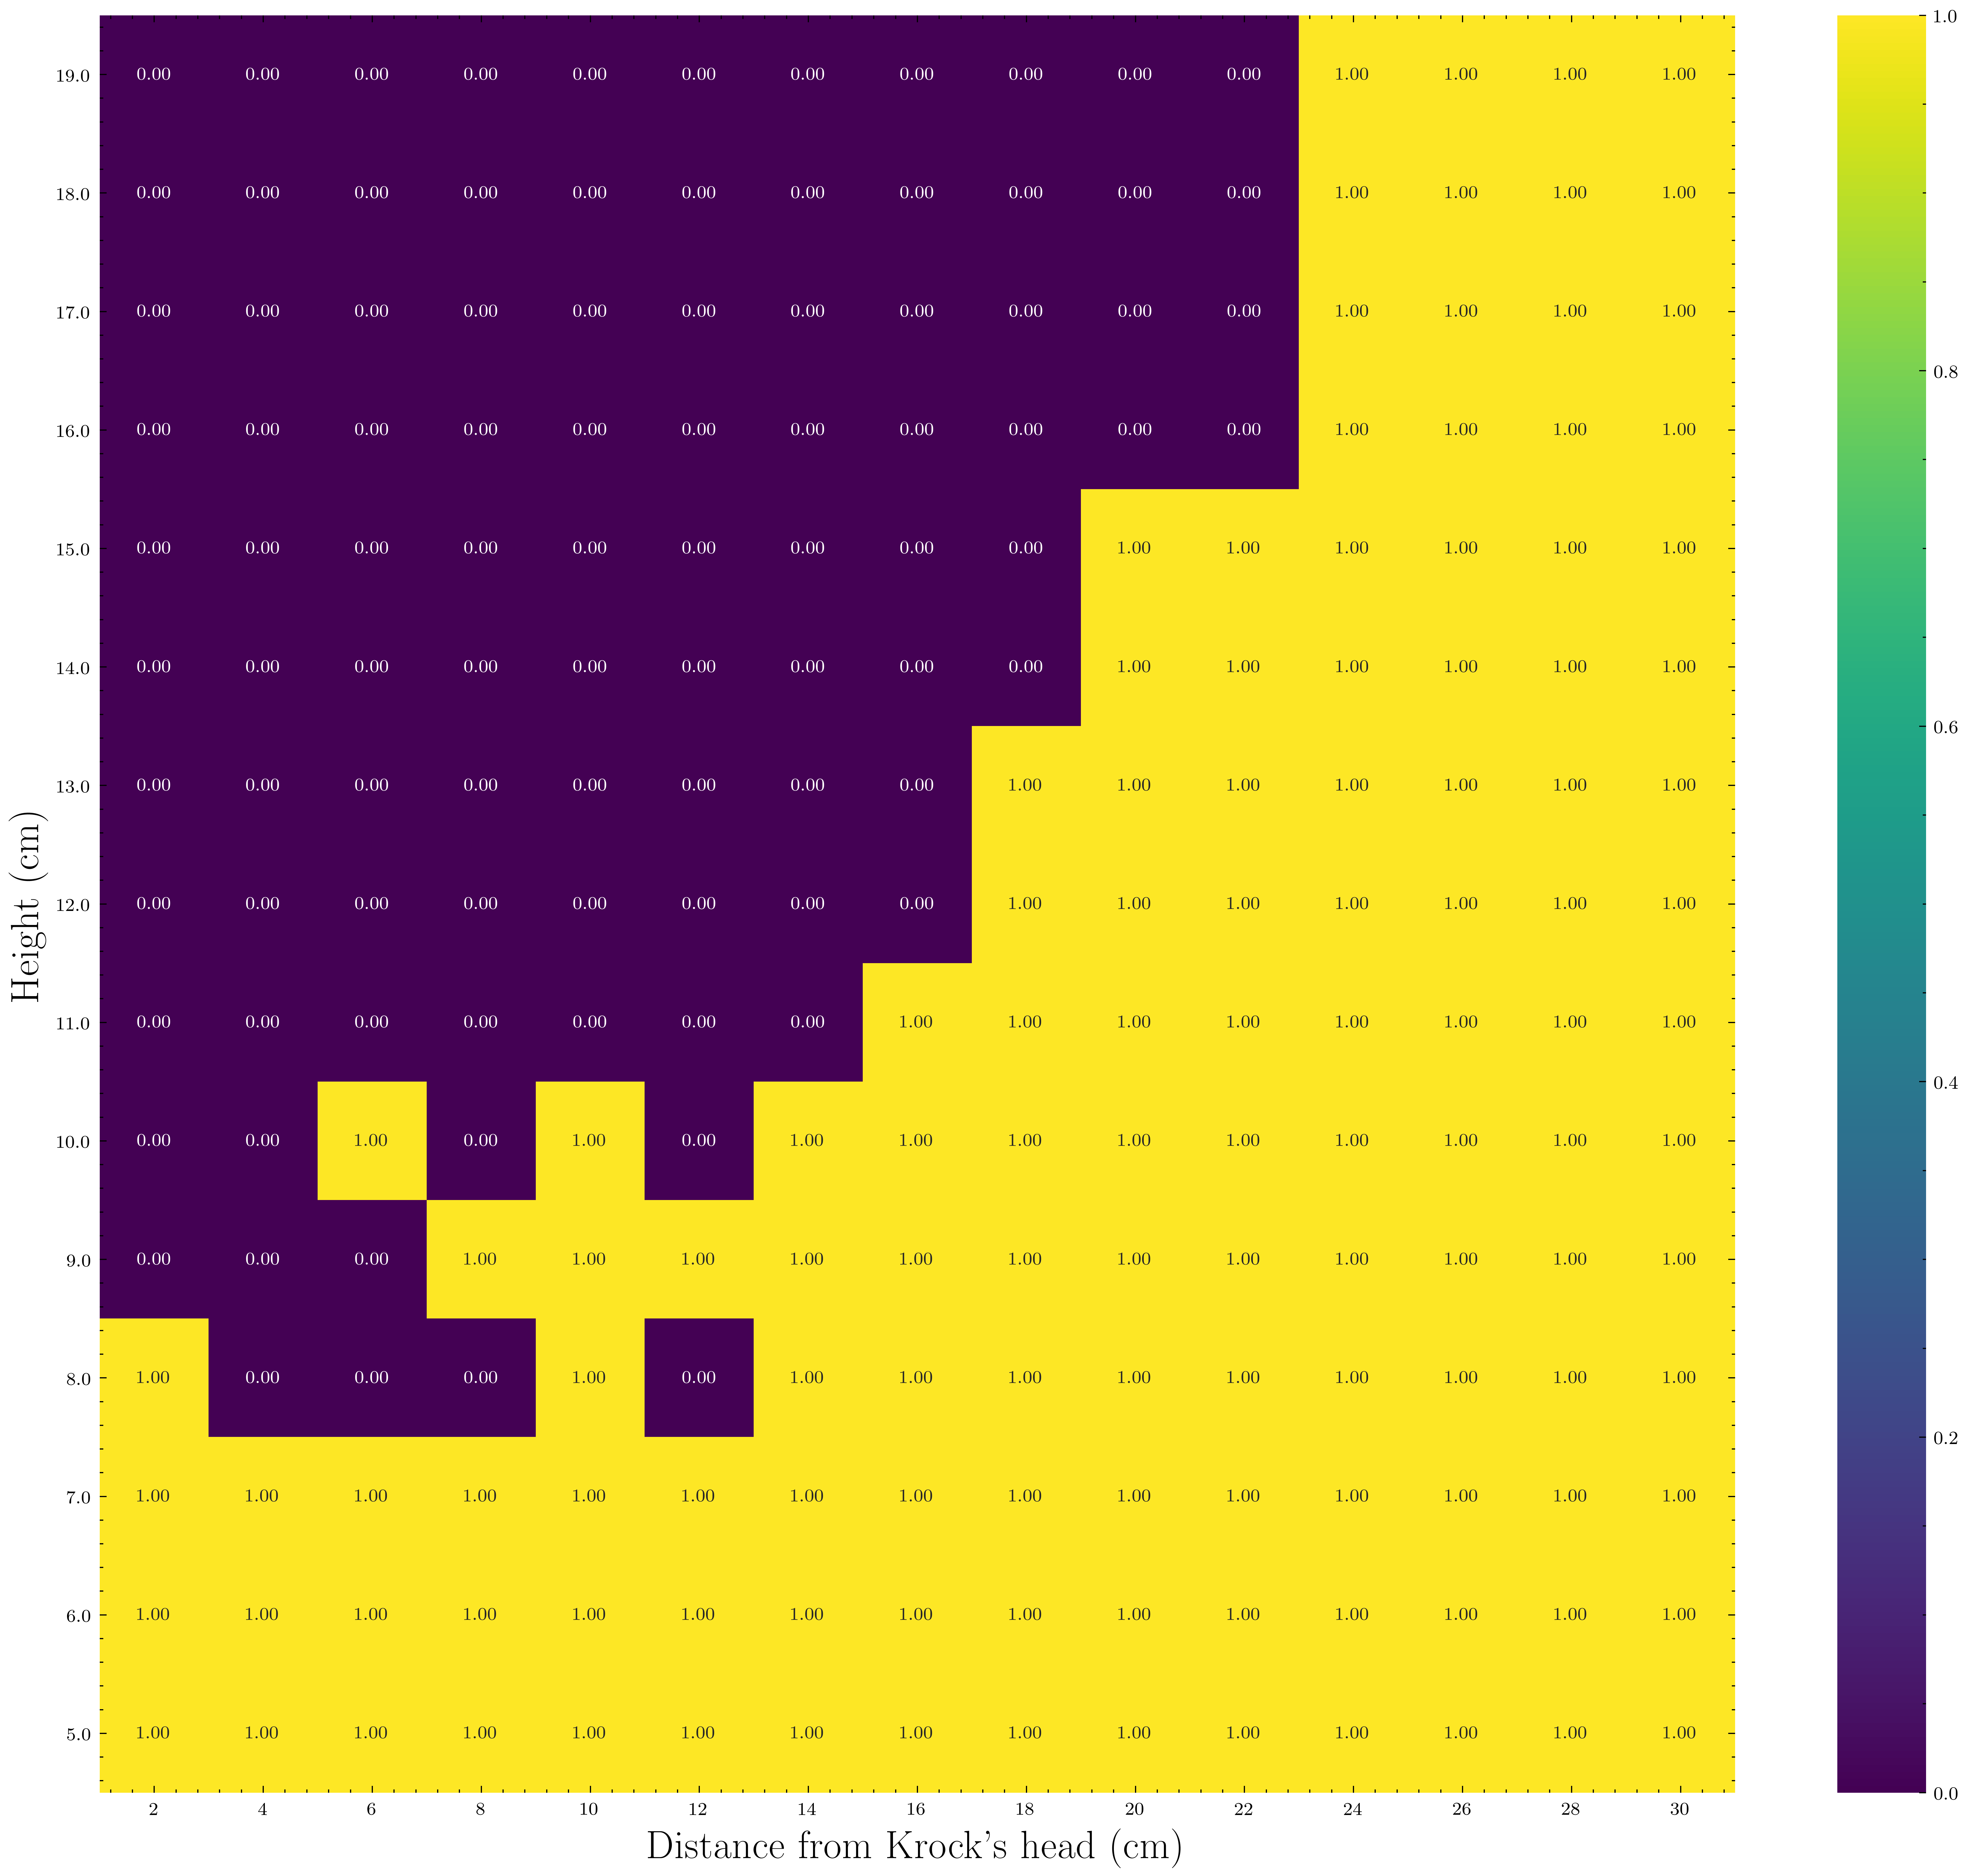

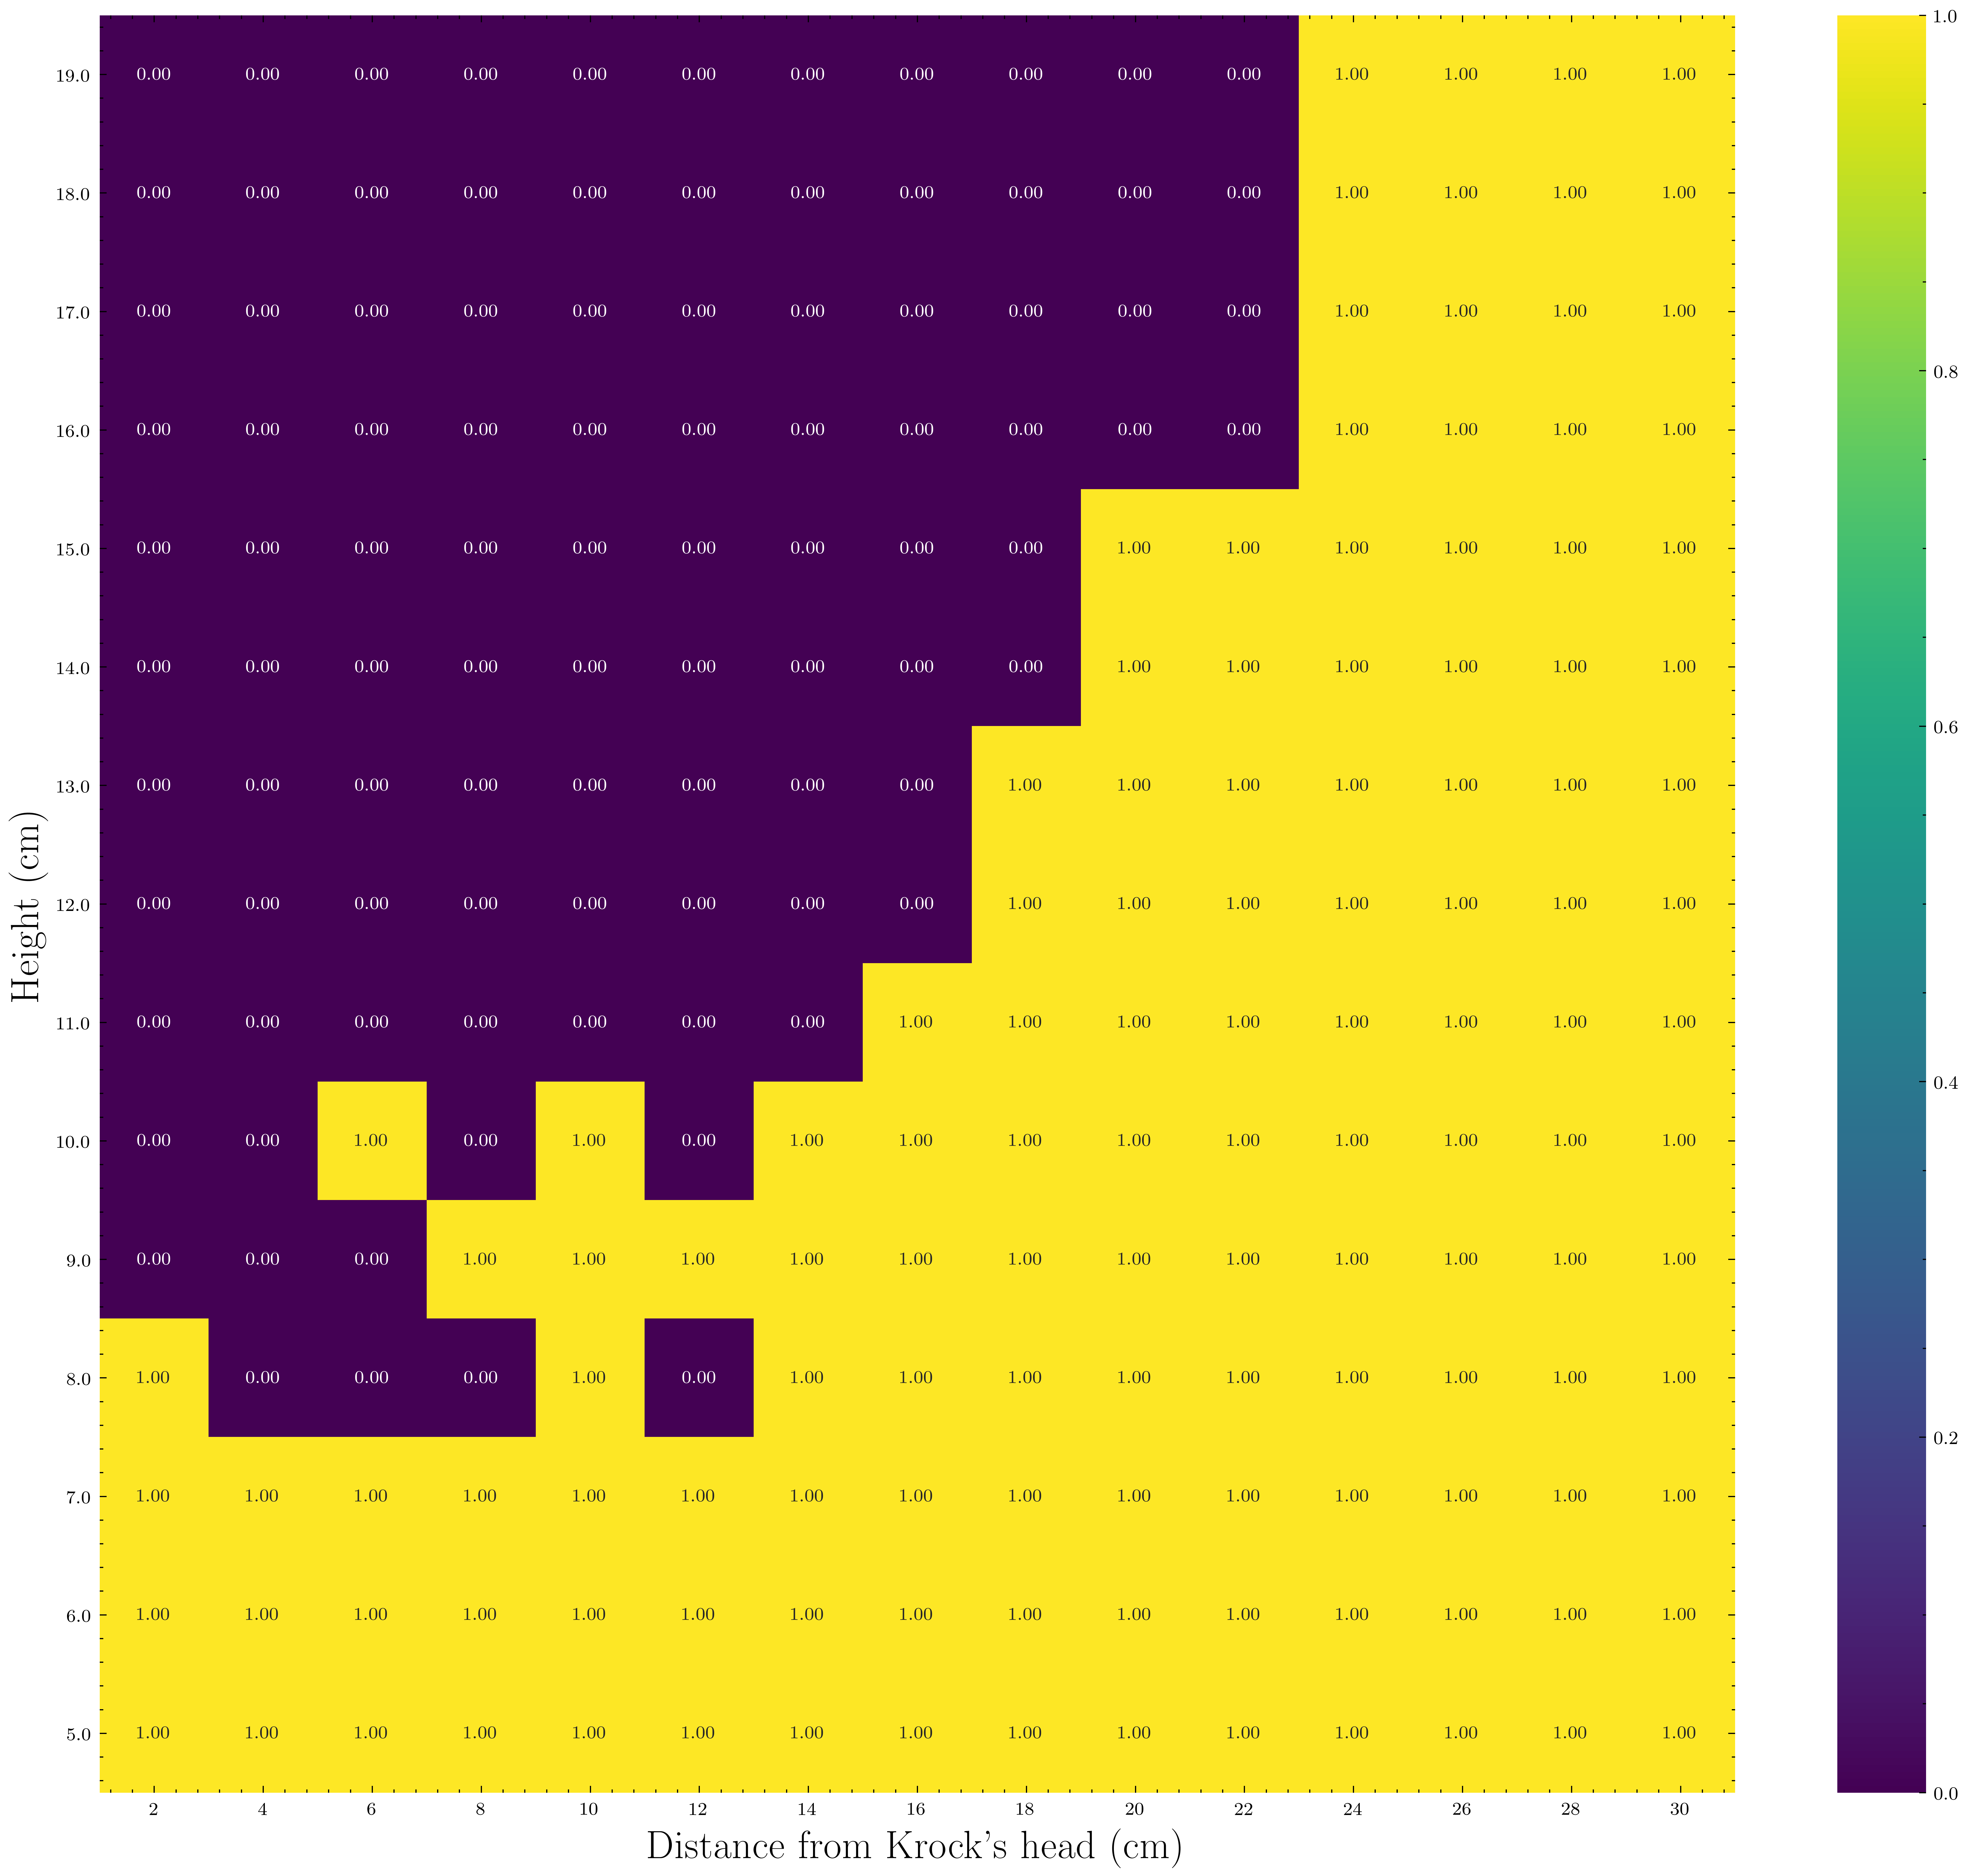

In [29]:
make_heatmap(advancements)
# fig.savefig(out_dir + '/walls_heights.png', transparent=True)

## Ramps
We can test the model against ramps with increasing hegihts

In [214]:
out_dir = '/home/francesco/Documents/Master-Thesis/papers/Thesis/img/5/custom_patches/ramp/'

heights = np.linspace(0, 2, 20) # from 1 to 20 cm (remember the res of 0.02cm/px) Krock height from ground is 4cm

walls = [RampPatch(KrockPatchExtractStrategy.patch_shape(0.7), strength=s, factors_func=lambda x: x ** 2)() 
         for s in heights ]

answer, explanation = get_answers_from_patches(walls)

explanation.df['height'] = heights ** 2
explanation.df.to_csv(out_dir + '/prediction.csv')
explanation.df

20


,out_0,out_1,prediction,height
0,5.084239e-05,9.999491e-01,1,0.000000
1,3.001864e-06,9.999970e-01,1,0.011080
2,2.400021e-14,1.000000e+00,1,0.044321
3,1.605168e-30,1.000000e+00,1,0.099723
4,0.000000e+00,1.000000e+00,1,0.177285
5,0.000000e+00,1.000000e+00,1,0.277008
6,0.000000e+00,1.000000e+00,1,0.398892
7,5.885853e-24,1.000000e+00,1,0.542936
8,1.033083e-06,9.999989e-01,1,0.709141
9,4.470575e-02,9.552943e-01,1,0.897507


In [215]:
plt.style.use(['science', 'ieee'])

# answer[9].add_advancement_using_simulator(seconds, time_window)
# save2d_and_2d(answer[9], out_dir, 1)
answer[10].add_advancement_using_simulator(seconds, time_window)
save2d_and_2d(answer[10], out_dir, 2)

36 39
success: 1


KeyboardInterrupt: 

In [217]:
# store all the walls for the thesis
for n, p in enumerate(answer):
    p.plot3d_mayavi(0.02, size=(513,513), distance=6, save_path=out_dir + '/all/{:02d}-3d.png'.format(n), azimuth=0, color=(0,0.5,0), elevation=35, mesh=True, vmax=1)

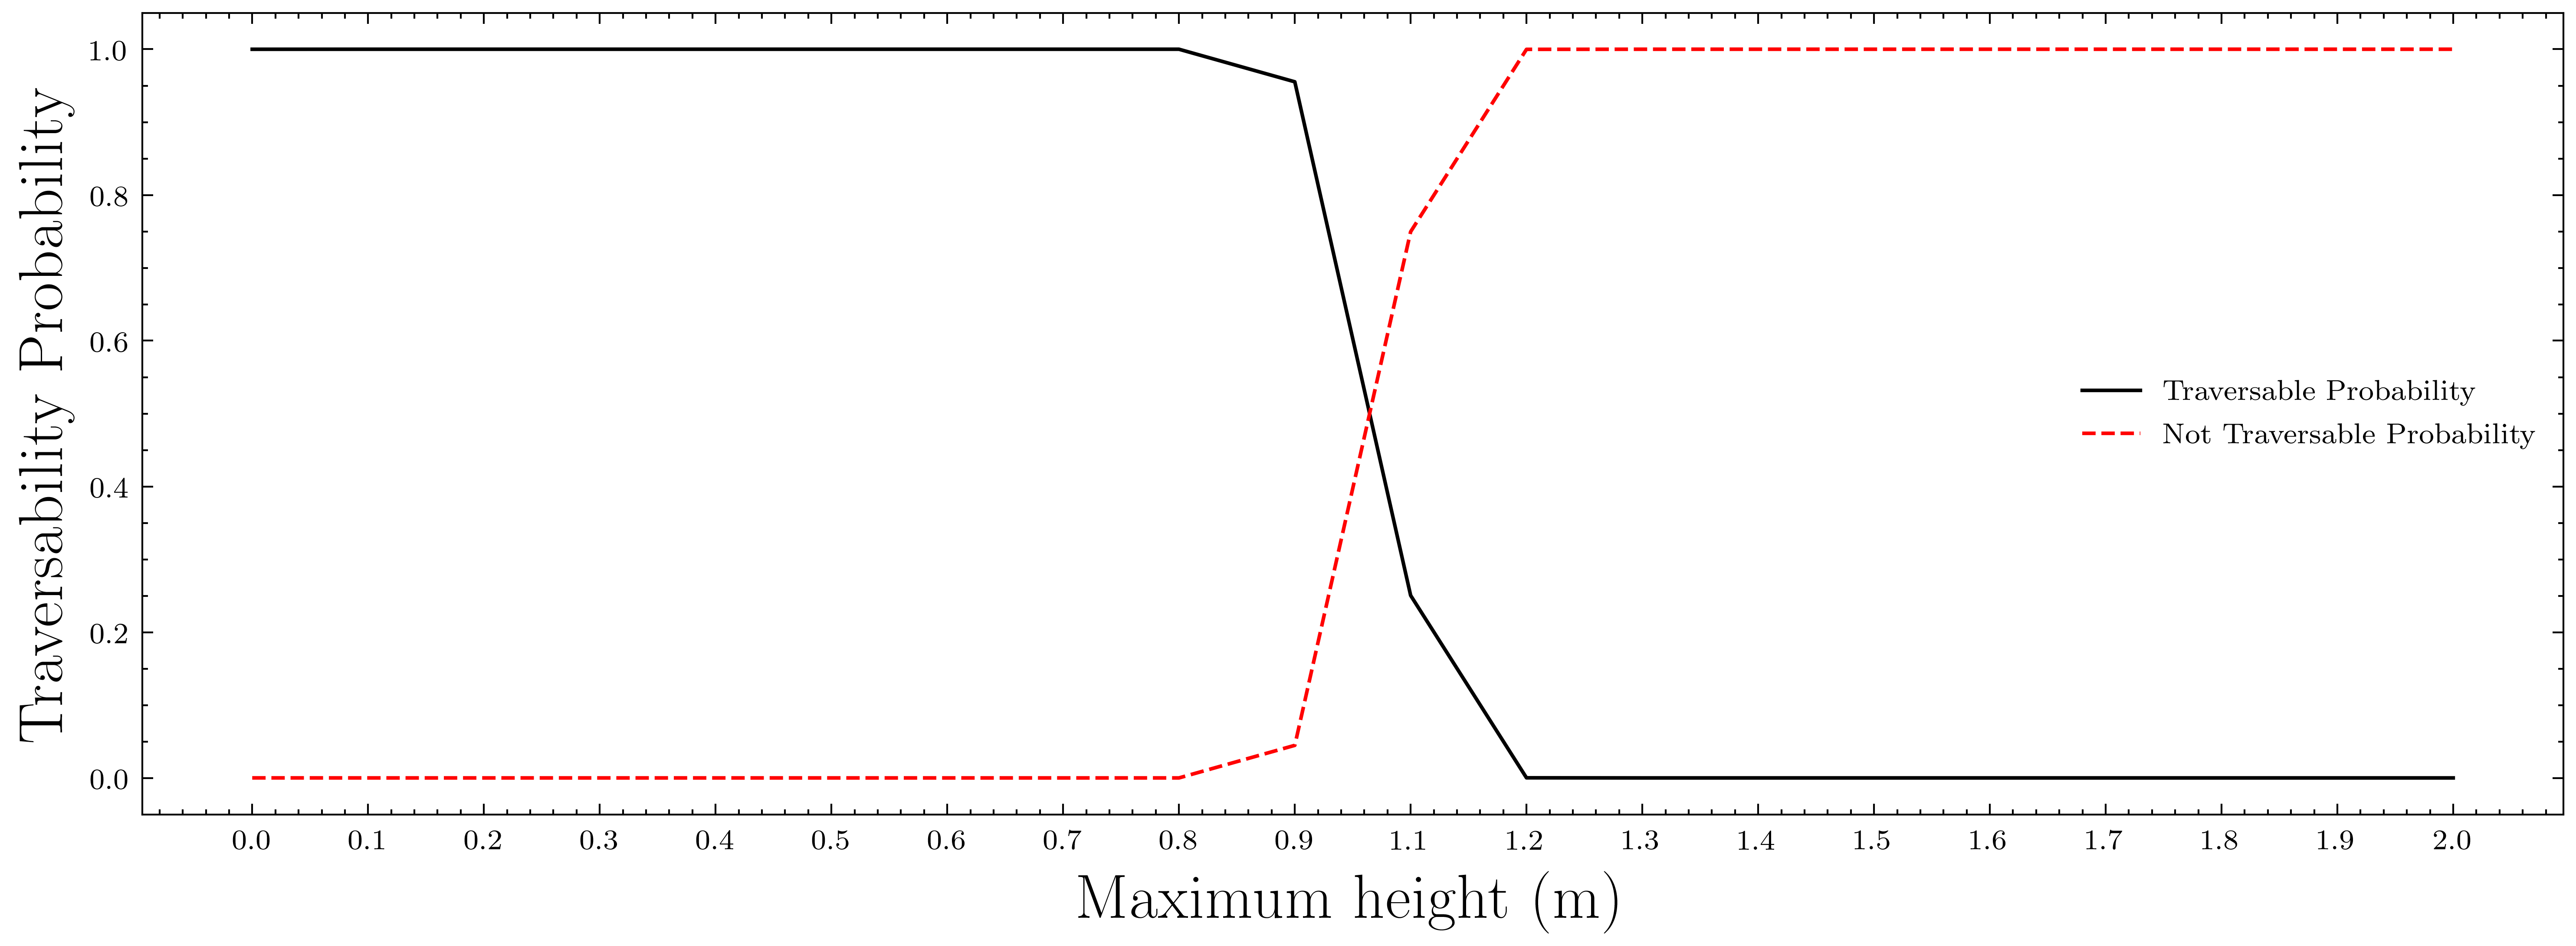

In [174]:
fig = plt.figure()
plt.plot(explanation.df['out_1'], label='Traversable Probability ')
plt.plot(explanation.df['out_0'], label='Not Traversable Probability')
ax = plt.gca()

ax.set_xticks(np.arange(len(heights)))
ax.set_xticklabels(['{:.1f}'.format(d) for d in heights], rotation=0)
matplotlib.rcParams['figure.figsize'] = (12,4)
ax.set_xlabel('Maximum height (m)',  fontsize=18)
ax.set_ylabel('Traversability Probability',  fontsize=18)
plt.legend()
plt.show()
fig.savefig(out_dir + '/predictions.png')

## Tunnel

In [212]:
out_dir = '/home/francesco/Documents/Master-Thesis/papers/Thesis/img/5/custom_patches/tunnel/'

offsets = np.arange(15, 25)

tunnels = [BarPatch(KrockPatchExtractStrategy.patch_shape(0.7), strength=0.5, offset=int(o), size=size)() 
         for o in offsets ]

In [213]:
answer, explanation = get_answers_from_patches(tunnels)

explanation.df['offset'] = offsets
explanation.df.to_csv(out_dir + 'prediction.csv')
explanation.df

10


,out_0,out_1,prediction,offset
0,2.802597e-45,1.000000e+00,1,15
1,0.000000e+00,1.000000e+00,1,16
2,0.000000e+00,1.000000e+00,1,17
3,0.000000e+00,1.000000e+00,1,18
4,0.000000e+00,1.000000e+00,1,19
5,4.533245e-08,1.000000e+00,1,20
6,8.181269e-02,9.181873e-01,1,21
7,1.975145e-01,8.024855e-01,1,22
8,1.000000e+00,8.615235e-11,0,23
9,9.904965e-01,9.503458e-03,0,24


In [201]:
# store all the walls for the thesis
for n, p in enumerate(answer):
    p.plot3d_mayavi(0.02, size=(513,513), distance=3.5, save_path=out_dir + '/all/{:02d}-3d.png'.format(n), azimuth=0, color=(0,0.5,0), elevation=35, mesh=True, vmax=1)

In [202]:
advs = []
for a in answer:
    a.add_advancement_using_simulator(seconds, time_window)
    advs.append(a.info['advancement'].iloc[25])


36 39
success: 1
36 39
success: 1
36 39
success: 1
36 39
success: 1
36 39
success: 1
36 39
success: 1
36 39
success: 1
36 39
success: 1
36 39
success: 1
36 39
success: 1
36 39
success: 1
36 39
success: 1
36 39
success: 1
36 39
success: 1
36 39
success: 1
36 39
success: 1
36 39
success: 1
36 39
success: 1
36 39
success: 1
36 39
success: 1
36 39
success: 1
36 39
success: 1
36 39
success: 1
36 39
success: 1


In [203]:
advs

[0.549211094283244,
 0.4275577062871233,
 0.5018231679483626,
 0.4948685687409234,
 0.5621958137384976,
 0.47963142140192094,
 0.5723897700181113,
 0.5487851044039403,
 0.4173632143880047,
 0.5252275184621344,
 0.5320100827236897,
 0.5268119314090568,
 0.547359170077387,
 0.5058494356549185,
 0.5348220810195733,
 0.4756551771570466,
 -0.02032492139614861,
 0.01850850664371839,
 0.13618935952451083,
 -0.382350010052304,
 0.5433739166790746,
 0.5381599118447618,
 0.5412057461389658,
 0.5435610717758208]

In [188]:
plt.style.use(['science', 'ieee'])

answer[19].add_advancement_using_simulator(seconds, time_window)
save2d_and_2d(answer[19], out_dir, 1)
answer[20].add_advancement_using_simulator(seconds, time_window)
save2d_and_2d(answer[20], out_dir, 2)

36 39
success: 1
36 39
success: 1
